# Initialization

In [1]:
# Loading
import torch
from torchvision import datasets, transforms, utils

# ---- Visualizing
import matplotlib.pyplot as plt
import numpy as np

# Loading Data

In [2]:
BATCH_SIZE = 16
N_EPOCHS = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
    ])

transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

testset = datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)   

## Visualizing some samples

Labels:  tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7])
Batch shape:  torch.Size([16, 1, 28, 28])


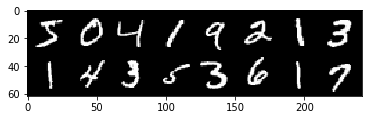

In [3]:
# functions to show an image

def show_batch(batch):
    im = utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)    
    


# Creating a MLP

In [4]:
def relu(x):
    return (x > 0) * x


def softmax(x, axis=1):
    '''Returns a matrix of size n_sample * n_features.'''
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def onehot(y, n_classes):
    '''Returns a matrix of size n_samples * n_classes with the one-hot
    representation of the category of sample i in line i-th of the matrix,
    that is a line full of zeros except for the j-th column that is equal to
    1, where j is the class of sample i.
    y is a vector of integers between 0 and n_classes - 1.
    y may have one or more lines. Each line is the label of each sample.'''
    
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

In [5]:
class MLP(object):
    
#    def __init__(self, d0, d1, d2, d3, mode='train', type='Zeros'
#                 datapath=None, model_path=None):
    def __init__(self, d0, d1, d2, d3, init_type='Zeros'):

        super(MLP, self).__init__()
        #self.mode = mode
        self.d0 = d0
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.init_type = init_type
        
        self.W1 = self.initialize_weights(d0, d1, type=self.init_type)
        self.W2 = self.initialize_weights(d1, d2, type=self.init_type)
        self.W3 = self.initialize_weights(d2, d3, type=self.init_type)
        
        self.b1 = np.zeros(d1)
        self.b2 = np.zeros(d2)
        self.b3 = np.zeros(d3)
        
        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]


    def initialize_weights(self, in_dim, out_dim, type='Zeros'):
        if type == 'Normal':           
            return np.random.normal(1, 1, size=(out_dim, in_dim))
            
        elif type == 'Glorot':
            dl = np.sqrt(6 / (in_dim + out_dim))
            return np.random.uniform(-dl, dl, size=(out_dim, in_dim))

        else:
            # Zeros
            return np.zeros(shape=(out_dim, in_dim))
            #return np.ones(shape=(out_dim, in_dim)) * 1e-3


   
    def forward(self, x):
        h1 = np.dot(x, self.W1.T) + self.b1
        a1 = self.activation(h1)
        h2 = np.dot(a1, self.W2.T) + self.b2
        a2 = self.activation(h2)
        o = np.dot(a2, self.W3.T) + self.b3
        os = softmax(o, axis=1)
        return h1, a1, h2, a2, o, os

    
    def activation(self, input):
        return relu(input)

    
    def loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)

    
    def backward(self, y, x, h1, a1, h2, a2, o, os, weight_decay=0):
        
        n_samples = x.shape[0]
        
        dl_do = os - y
        
        dl_da2 = np.dot(dl_do, self.W3)
        dl_dh2 = (h2 > 0) * dl_da2
        dl_da1 = np.dot(dl_dh2, self.W2)
        dl_dh1 = (h1 > 0) * dl_da1
 
        dl_dW3 = np.dot(dl_do.T, a2) / n_samples + weight_decay * self.W3
        dl_db3 = dl_do.mean(axis=0)
        dl_dW2 = np.dot(dl_dh2.T, a1) / n_samples + weight_decay * self.W2
        dl_db2 = dl_dh2.mean(axis=0)
        dl_dW1 = np.dot(dl_dh1.T, x) / n_samples + weight_decay * self.W1
        dl_db1 = dl_dh1.mean(axis=0)
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3   

    
#    def update(self,grads,..):

        

    def train(self, trainloader, n_epochs=10, eta=1e-1, weight_decay=0.):
        '''data contains one batch with inputs x and targets y'''
        avg_loss = np.zeros(n_epochs)
        for epoch in range(n_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                
                # get the inputs and labels
                x, y = data
                
                # flatten data
                x = x.view(BATCH_SIZE, -1)
                
                y = onehot(y, 10)
                
                h1, a1, h2, a2, o, os = self.forward(x)
                avg_grads = self.backward(y, x, h1, a1, h2, a2, o, os, weight_decay)
                #avg_loss[epoch] = self.loss(os, y)
                
                # update grads for each parameter
                for p, grad in zip(self.parameters, avg_grads):
                    p -= eta * grad
                            
            avg_loss[epoch] = self.loss(os, y)
            print('Epoch %2d loss: %.3f' %
                      (epoch + 1, avg_loss[epoch]))    
        return avg_loss
    
    
    def predict(self, x):
        _, _, _, _, _, os = self.forward(x)
        return os.argmax(axis=1)

    
    def test(self, x, y):
        _, _, _, _, _, os = self.forward(x)       
    

# Training

During the test phase, we started with a much smaller network, namely we had used $d_1=64$ and $d_2=128$. But we increased it to attain the minimal number of 500,000 parameters. Once we increased it, we immediately obtained an accuracy higher than 97%. At that time, we were always using a batch size of 4 and a learning rate $\eta=0.1$. We later increased the batch size to 16 to improve performance by reducing the number of batches.

In [6]:
d0 = 28 * 28
d1 = 512
d2 = 512
d3 = 10

n_parameters = d0 * d1 + d1 + d1 * d2 + d2 + d2 * d3 + d3
print('Total number of parameters: %d' % n_parameters)

Total number of parameters: 669706


In [7]:
def get_accuracy(model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data in testloader:
        images, labels = data
        x = images.view(BATCH_SIZE, -1)
        pred = model.predict(x)
        c = (pred == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    print('Model with %s initialization' % (model.init_type))
    for i in range(10):
        print('Accuracy of %1s: %.1f%%' % (
            i, 100 * class_correct[i] / class_total[i]))

    print()
    print('Overall accuracy: %.1f%%\n\n' %
          (100 * sum(class_correct) / sum(class_total)))


Epoch  1 loss: 2.313
Epoch  2 loss: 2.313
Epoch  3 loss: 2.313
Epoch  4 loss: 2.313
Epoch  5 loss: 2.313
Epoch  6 loss: 2.313
Epoch  7 loss: 2.313
Epoch  8 loss: 2.313
Epoch  9 loss: 2.313
Epoch 10 loss: 2.313
Zeros executed in 2.3 minutes

Model with Zeros initialization
Accuracy of 0: 0.0%
Accuracy of 1: 0.0%
Accuracy of 2: 0.0%
Accuracy of 3: 0.0%
Accuracy of 4: 0.0%
Accuracy of 5: 0.0%
Accuracy of 6: 0.0%
Accuracy of 7: 100.0%
Accuracy of 8: 0.0%
Accuracy of 9: 0.0%

Overall accuracy: 10.3%


Epoch  1 loss: 2.313
Epoch  2 loss: 2.313
Epoch  3 loss: 2.313
Epoch  4 loss: 2.313
Epoch  5 loss: 2.313
Epoch  6 loss: 2.313
Epoch  7 loss: 2.313
Epoch  8 loss: 2.313
Epoch  9 loss: 2.313
Epoch 10 loss: 2.313
Normal executed in 2.3 minutes

Model with Normal initialization
Accuracy of 0: 0.0%
Accuracy of 1: 0.0%
Accuracy of 2: 0.0%
Accuracy of 3: 0.0%
Accuracy of 4: 0.0%
Accuracy of 5: 0.0%
Accuracy of 6: 0.0%
Accuracy of 7: 100.0%
Accuracy of 8: 0.0%
Accuracy of 9: 0.0%

Overall accuracy: 10

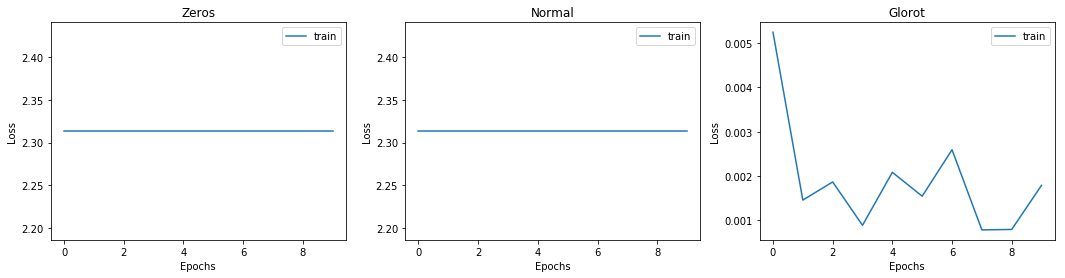

In [8]:
import time

plt.figure(figsize=(18, 4))
for i, init_type in enumerate(['Zeros','Normal','Glorot']):
#for i, init_type in enumerate(['Glorot']):

    start_time = time.time()
    model = MLP(d0, d1, d2, d3, init_type)
    loss = model.train(trainloader, n_epochs=N_EPOCHS, eta=1e-1, weight_decay=0.)
    total_time = time.time() - start_time
    print('%s executed in %.1f minutes\n' % (init_type, total_time / 60.0))
    axis = plt.subplot(1, 3, i + 1)
    axis.plot(range(N_EPOCHS), loss, label='train')
    axis.set_title(init_type)
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    get_accuracy(model)

# Prediction

Prediction:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]


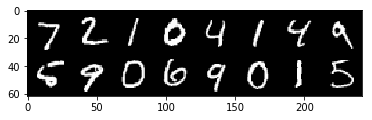

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()
x = images.view(BATCH_SIZE, -1)
show_batch(images)
print('Prediction: ', model.predict(x))

# Finite Differences

In [10]:
def finite_diff(model, x, y, param_list, p=10, eps=1e-5):
    eps = eps * 2
    h1, a1, h2, a2, o, os = model.forward(x)
    gradients_bprop = model.backward(y, x, h1, a1, h2, a2, o, os)
    loss_minus = model.loss(os, y)
    gradients_finite_diff = []
    for prm in param_list:
        grad_fdiff = np.zeros(shape=prm.shape)
        for index, v in np.ndenumerate(prm):
            if sum(index) > p:
                break
            else:
                prm[index] += eps
                _, _, _, _, _, os = model.forward(x)
                loss_plus = model.loss(os, y)
                grad_fdiff[index] = (loss_plus - loss_minus) / eps
                prm[index] -= eps
        gradients_finite_diff.append(grad_fdiff)
    return gradients_finite_diff

In [11]:
def get_max_diff(model, x, y, N_list, param_idx, max_p=10):
    '''Returns a vector with the maximal difference
    for different values of N in N_list between the
    true gradient calculated by back propagation and
    the gradient calculated by finite differences'''
    
    max_diff = np.zeros(len(N_list))
    param_list = model.parameters[param_idx]
    
    # p is the maximum number of elements of the weight
    # matrix that will be considered
    p = min(max_p, model.parameters[param_idx].size)

    h1, a1, h2, a2, o, os = model.forward(x)
    BP = model.backward(y, x, h1, a1, h2, a2, o, os)[param_idx]
    for idx, N in enumerate(N_list):
        eps = 1 / N
        FD = finite_diff(model, x, y, param_list, p, eps)[param_idx]
    
        # flattens the difference matrix
        diff = (BP - FD).reshape(model.parameters[param_idx].size)
    
        diff = diff[0:p]
        max_diff[idx] = np.max(np.abs(diff))
    
    return max_diff


[[1.00000000e+00 2.93618707e-02]
 [2.00000000e+00 2.87753269e-02]
 [3.00000000e+00 2.82990681e-02]
 [4.00000000e+00 2.78495534e-02]
 [5.00000000e+00 2.74106066e-02]
 [1.00000000e+01 2.52629783e-02]
 [2.00000000e+01 2.48119387e-02]
 [3.00000000e+01 2.48119387e-02]
 [4.00000000e+01 2.48119387e-02]
 [5.00000000e+01 2.48119387e-02]
 [1.00000000e+02 2.48119387e-02]
 [2.00000000e+02 2.48119387e-02]
 [3.00000000e+02 2.48119387e-02]
 [4.00000000e+02 2.48119387e-02]
 [5.00000000e+02 2.48119387e-02]
 [1.00000000e+03 2.48119387e-02]
 [2.00000000e+03 2.48119387e-02]
 [3.00000000e+03 2.48119387e-02]
 [4.00000000e+03 2.48119387e-02]
 [5.00000000e+03 2.48119387e-02]
 [1.00000000e+04 2.48119387e-02]
 [2.00000000e+04 2.48119387e-02]
 [3.00000000e+04 2.48119387e-02]
 [4.00000000e+04 2.48119387e-02]
 [5.00000000e+04 2.48119387e-02]
 [1.00000000e+05 2.48119387e-02]
 [2.00000000e+05 2.48119387e-02]
 [3.00000000e+05 2.48119387e-02]
 [4.00000000e+05 2.48119387e-02]
 [5.00000000e+05 2.48119387e-02]]


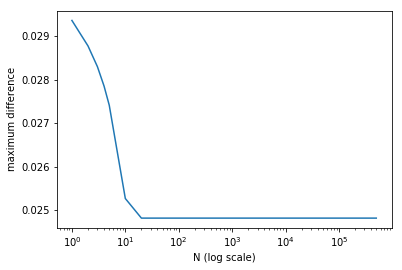

In [12]:
N_list = []
PARAM_IDX = 3       # W2 is the 3rd parameter

dataiter = iter(trainloader)
images, labels = dataiter.next()

# get the first sample and its label
x = images[0].view(1, -1)
y = onehot(labels, 10)[0]

for i in range(6):    # 0 to 5
    for k in range(1,6):      # 1 to 5
        N_list.append(k * 10**i)

max_diff = get_max_diff(model, x, y, N_list, PARAM_IDX)

plt.semilogx(N_list, max_diff)
plt.xlabel('N (log scale)')
plt.ylabel('maximum difference')

print(np.c_[N_list, max_diff])